In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load Fashion MNIST dataset
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Define VAE components
latent_dim = 2  # Dimensionality of the latent space

# Encoder
def build_encoder():
    inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    return keras.Model(inputs, [z_mean, z_log_var], name="encoder")

# Sampling Layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Decoder
def build_decoder():
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    return keras.Model(latent_inputs, outputs, name="decoder")

# VAE Model Class
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = Sampling()([z_mean, z_log_var])
        reconstructed = self.decoder(z)
        return reconstructed

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = Sampling()([z_mean, z_log_var])
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(data, reconstruction))
            kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
            total_loss = reconstruction_loss + kl_loss
        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return {"loss": total_loss}

# Instantiate and compile VAE
encoder = build_encoder()
decoder = build_decoder()
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

# Train VAE
vae.fit(x_train, epochs=10, batch_size=128, validation_data=(x_test, None))

# Generate new samples from random latent vectors
def generate_new_samples(n=10):
    random_latent_vectors = np.random.normal(size=(n, latent_dim))
    generated_images = decoder.predict(random_latent_vectors)
    return generated_images

# Plot generated samples
def plot_generated_images(images, n=10):
    plt.figure(figsize=(10, 2))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i].squeeze(), cmap="gray")
        plt.axis("off")
    plt.show()

# Generate and plot new samples
new_samples = generate_new_samples()
plot_generated_images(new_samples)

# Latent space interpolation
def interpolate_images(start, end, steps=10):
    vectors = np.linspace(start, end, steps)
    images = decoder.predict(vectors)
    plot_generated_images(images, steps)

# Example interpolation between two random points
z1, z2 = np.random.normal(size=(2, latent_dim))
interpolate_images(z1, z2)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5057

ValueError: No loss to compute. Provide a `loss` argument in `compile()`.

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.7MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 204kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.70MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 7.61MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Epoch [1/10], Step [100/938], Loss: 318.0870
Epoch [1/10], Step [200/938], Loss: 256.8149
Epoch [1/10], Step [300/938], Loss: 281.1279
Epoch [1/10], Step [400/938], Loss: 265.5182
Epoch [1/10], Step [500/938], Loss: 252.9008
Epoch [1/10], Step [600/938], Loss: 262.7972
Epoch [1/10], Step [700/938], Loss: 258.4593
Epoch [1/10], Step [800/938], Loss: 276.8938
Epoch [1/10], Step [900/938], Loss: 259.1496
Epoch [2/10], Step [100/938], Loss: 258.2561
Epoch [2/10], Step [200/938], Loss: 260.5404
Epoch [2/10], Step [300/938], Loss: 254.0799
Epoch [2/10], Step [400/938], Loss: 239.6485
Epoch [2/10], Step [500/938], Loss: 252.2718
Epoch [2/10], Step [600/938], Loss: 229.1728
Epoch [2/10], Step [700/938], Loss: 255.4994
Epoch [2/10], Step [800/938], Loss: 239.8372
Epoch [2/10], Step [900/938], Loss: 243.1584
Epoch [3/10], Step [100/938], Loss: 248.2739
Epoch [3/10], Step [200/938], Loss: 249.1437
Epoch [3/10

<ipython-input-4-b755ecea92f1>:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('vae_model.pth'))


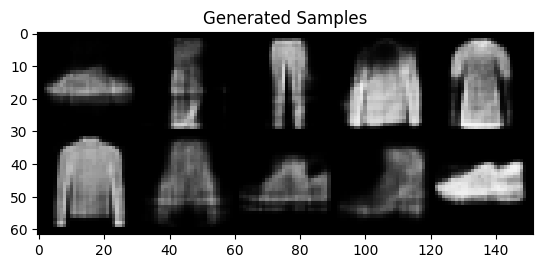

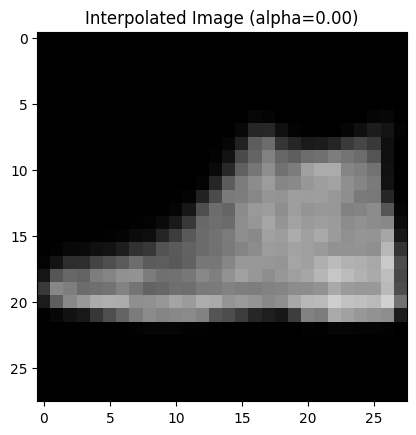

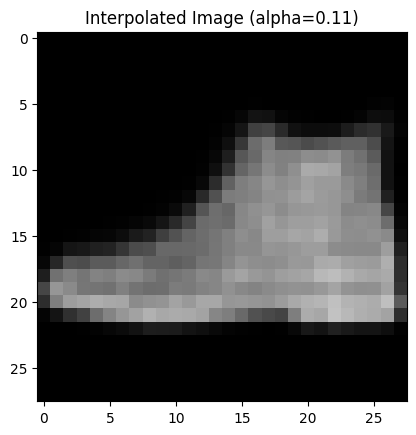

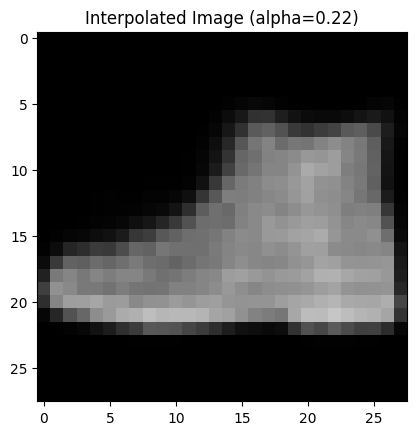

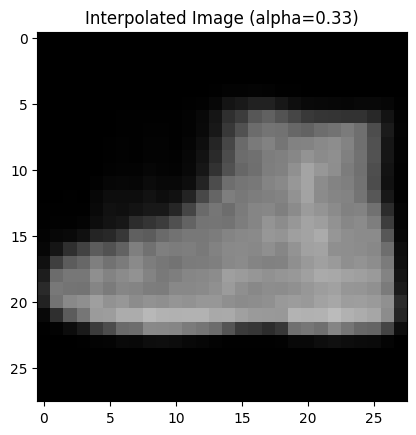

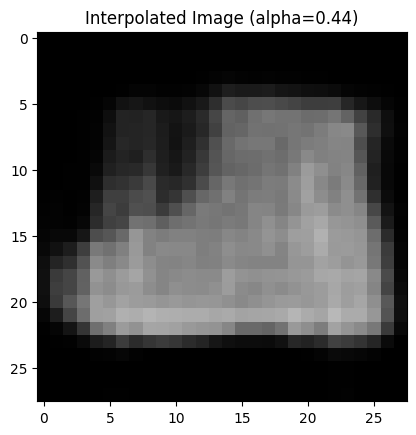

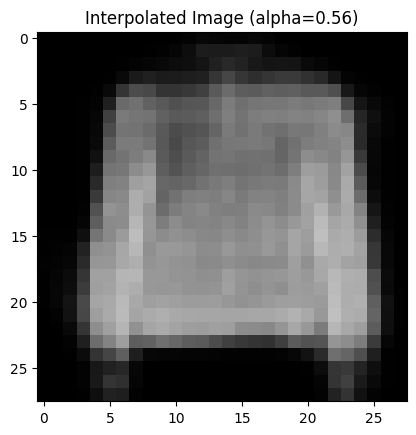

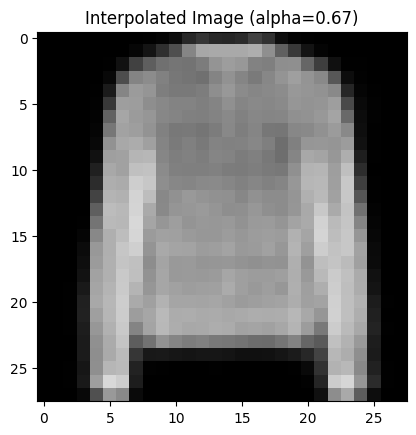

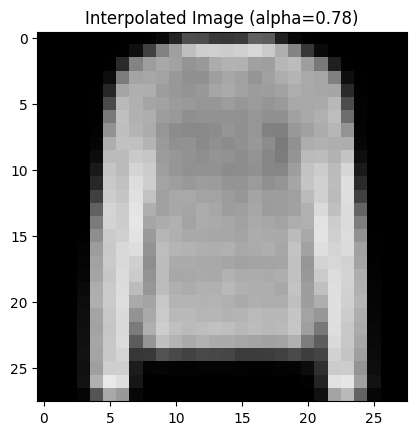

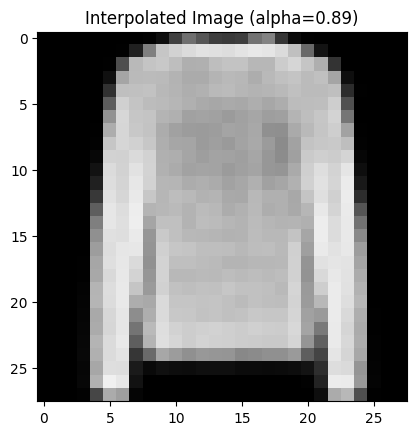

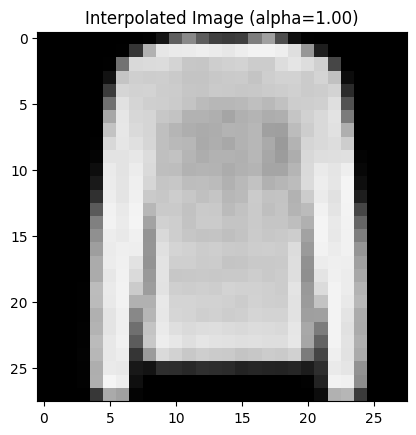

Reconstruction Loss (example batch): 277.6602


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
import numpy as np

# Define the VAE model
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2) # Mean and log variance
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid() # Output is between 0 and 1 (pixel intensities)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std)
        return mu + epsilon * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu = encoded[:, :latent_dim]
        logvar = encoded[:, latent_dim:]
        z = self.reparameterize(mu, logvar)  # Sample from the latent space
        decoded = self.decoder(z)
        return decoded, mu, logvar


# Data loading and preprocessing
transform = transforms.ToTensor()
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model initialization
input_dim = 784  # 28x28 images
hidden_dim = 512
latent_dim = 64
model = VAE(input_dim, hidden_dim, latent_dim)

# Loss function and optimizer
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 10  # Reduced for demonstration
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(train_loader):
        x = x.view(-1, input_dim)  # Flatten the images
        x_recon, mu, logvar = model(x)
        loss = loss_function(x_recon, x, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()/len(x):.4f}')


# Save the trained model
torch.save(model.state_dict(), 'vae_model.pth')

# --- Latent Space Exploration and Sample Generation ---

# Load the trained model
model = VAE(input_dim, hidden_dim, latent_dim)  # Re-initialize
model.load_state_dict(torch.load('vae_model.pth'))
model.eval()

# 1. Generating new samples from the latent space:
num_samples = 10
with torch.no_grad():
    z = torch.randn(num_samples, latent_dim) # Sample from standard normal distribution
    generated_images = model.decoder(z)
    generated_images = generated_images.view(-1, 1, 28, 28) # Reshape to image format

    # Save generated images
    save_image(generated_images, 'generated_samples.png')
    # Display generated Images
    grid = make_grid(generated_images, nrow=5)
    plt.imshow(grid.permute(1, 2, 0))
    plt.title("Generated Samples")
    plt.show()



# 2. Interpolating in the latent space:
with torch.no_grad():
    # Choose two images
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    img1 = images[0].view(-1, input_dim)
    img2 = images[1].view(-1, input_dim)

    _, mu1, logvar1 = model(img1)
    z1 = model.reparameterize(mu1, logvar1)

    _, mu2, logvar2 = model(img2)
    z2 = model.reparameterize(mu2, logvar2)

    num_interpolated_images = 10
    for alpha in np.linspace(0, 1, num_interpolated_images):
        z_interp = (1 - alpha) * z1 + alpha * z2
        generated_interp_image = model.decoder(z_interp)
        generated_interp_image = generated_interp_image.view(-1, 1, 28, 28)
        save_image(generated_interp_image, f'interpolated_image_{alpha:.2f}.png')
        grid = make_grid(generated_interp_image, nrow=1)
        plt.imshow(grid.permute(1, 2, 0))
        plt.title(f"Interpolated Image (alpha={alpha:.2f})")
        plt.show()

# --- Performance Metrics (Example -  using one batch from the test set) ---
with torch.no_grad():
    test_images, _ = next(iter(test_loader))  # Get a batch of test images
    test_images = test_images.view(-1, input_dim)
    reconstructed_images, _, _ = model(test_images)
    reconstruction_loss = loss_function(reconstructed_images, test_images, _, _).item() / len(test_images)
    print(f"Reconstruction Loss (example batch): {reconstruction_loss:.4f}")

# --- Final Report (Summarized) ---

# Introduction:
# Variational Autoencoders (VAEs) are generative models that learn a latent representation of data.  They consist of an encoder that maps input data to a distribution in the latent space and a decoder that maps points from the latent space back to the data space.

# Implementation Details:
# The VAE was trained on the Fashion-MNIST dataset. The model architecture consisted of linear layers with ReLU activations. The latent space dimension was set to 64.  The loss function combined Binary Cross-Entropy (reconstruction loss) and KL divergence (regularization).

# Results & Analysis:
# - New samples were generated by sampling from the latent space's prior distribution (standard normal) and decoding these samples.
# - Interpolation in the latent space was performed by linearly combining the latent vectors of two images and decoding the intermediate vectors. This showed smooth transitions between the two clothing items.
# - A reconstruction loss on a sample batch of test data was used as a basic performance metric.  More sophisticated metrics could be added.

# Conclusion:
# This notebook demonstrated the basic functionalities of a VAE, including training, sample generation, and latent space manipulation. It visually showed the  smoothness and semantic organization of the latent space through interpolation.  Further experiments could explore different architectures, loss functions, or applications like anomaly detection or image editing.